# Object masks in images from prompts with SAM 2

In [8]:
from mask_maker import *

import rawpy
import numpy as np
import matplotlib.pyplot as plt

In [9]:

GAMA = 0.01
MASK_DONE = False

path_S = "./BDD/Reel/Buddha_4/Stray/DSC_9646.NEF"
path_SL = "./BDD/Reel/Buddha_4/Stray&PS/DSC_9653.NEF"
path_L_true = "./BDD/Reel/Buddha_4/PS/DSC_9505.NEF"


In [10]:

GAMA = 0.01
MASK_DONE = False

# path_S = "./BDD/Reel/SourisOrdi/Stray/SO00001.ARW"
# path_SL = "./BDD/Reel/SourisOrdi/Stray&PS/SO00002.ARW"
# path_L_true = "./BDD/Reel/SourisOrdi/PS/SO00003.ARW"


using device: cpu
Mask saved to ./BDD/Reel/Buddha_4/Stray&PS\mask.png


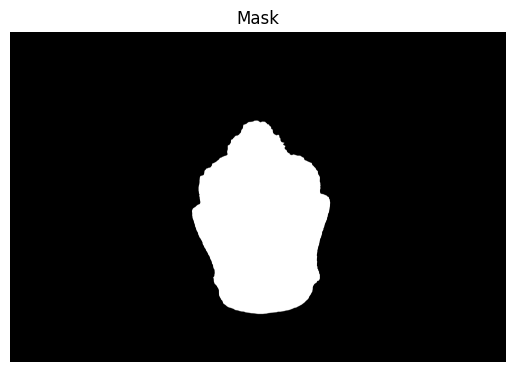

In [11]:
if MASK_DONE:
    MASK = Image.open("./BDD/Reel/Buddha_4/mask.png").convert("L")
    MASK = np.array(MASK) / 255.0
else:
    MASK = make_just_one_mask(path_SL, "large")

plt.imshow(MASK, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [12]:
def load_image_raw(path):
    """
    Charge une image RAW et retourne les données brutes du capteur
    sous forme de tableau numpy.
    """
    img = rawpy.imread(path)
    data_img = img.raw_image_visible.astype(np.float32)
    date_img_masked = data_img * MASK
    img.raw_image_visible[:, :] = date_img_masked.astype(np.uint16)
    return img


def diff_raw(raw_1, raw_2):
    data_1 = raw_1.raw_image_visible.astype(np.float32)
    data_2 = raw_2.raw_image_visible.astype(np.float32)

    diff = data_1 - data_2

    # On centre autour du niveau noir du capteur
    black = raw_1.black_level_per_channel[0]
    diff += black

    # Clip dans la dynamique 16 bits
    diff = np.clip(diff, 0, 65535)

    raw_1.raw_image_visible[:, :] = diff.astype(np.uint16)

    return raw_1


def show_raw_and_post(title, raw, gamma=1):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title)

    raw_data = raw.raw_image_visible
    axes[0].imshow(raw_data, cmap='gray')
    axes[0].set_title("RAW brut (Bayer)")
    axes[0].axis("off")

    raw_rgb = raw.postprocess(
        use_auto_wb=False,
        no_auto_bright=True,
        gamma=(gamma,gamma),
        output_bps=16
    )
    axes[1].imshow(raw_rgb)
    axes[1].set_title("Dématriçage postprocess")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

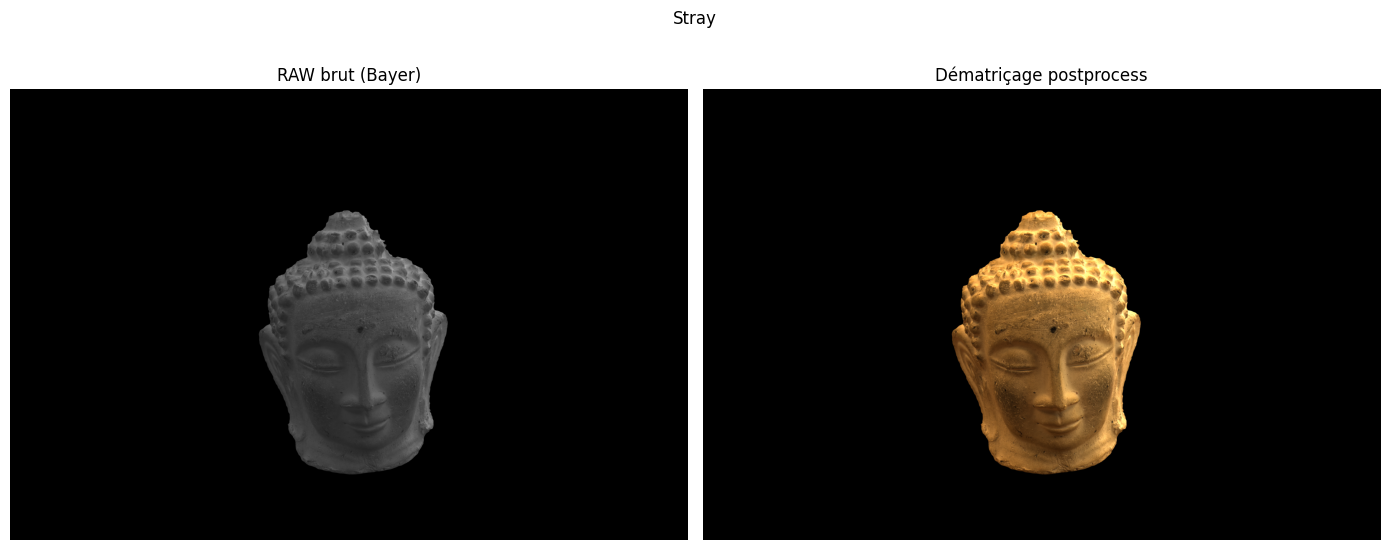

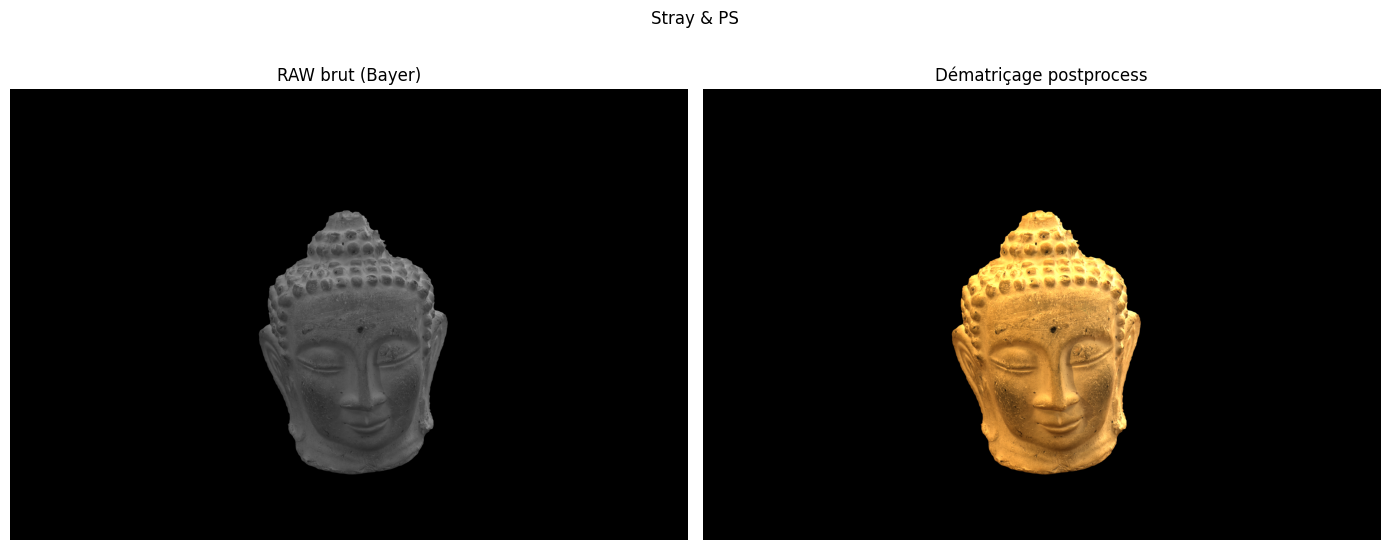

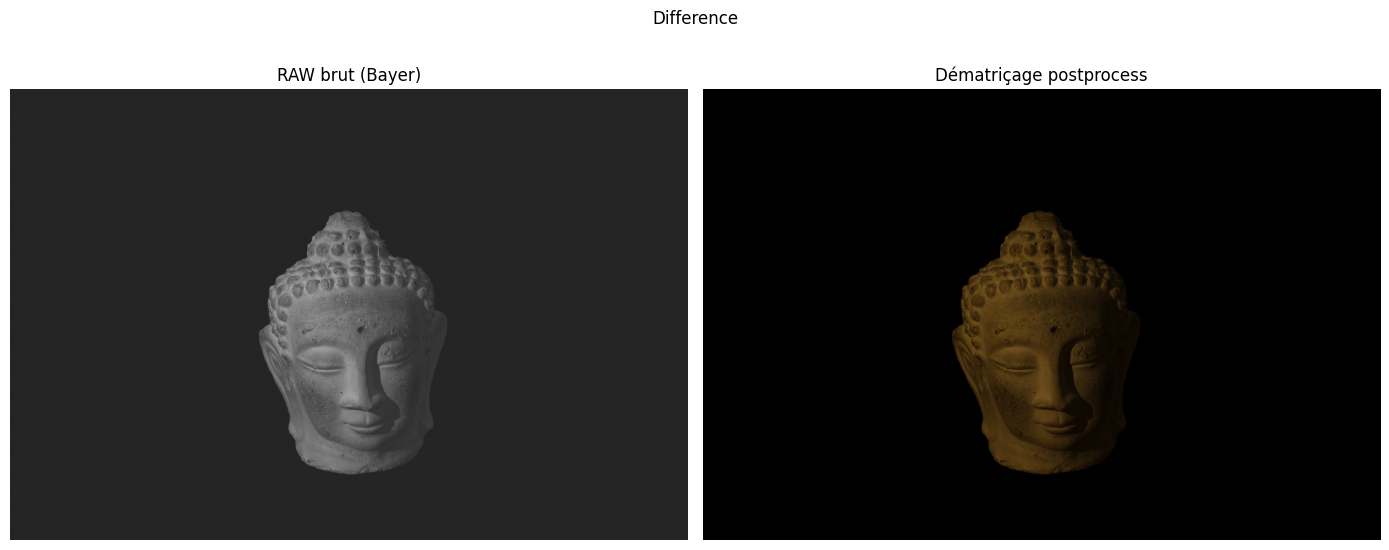

In [13]:
S = load_image_raw(path_S)
show_raw_and_post("Stray", S, GAMA)

SL = load_image_raw(path_SL)
show_raw_and_post("Stray & PS", SL, GAMA)

L_pred = diff_raw(SL, S)
show_raw_and_post("Difference", L_pred, GAMA)

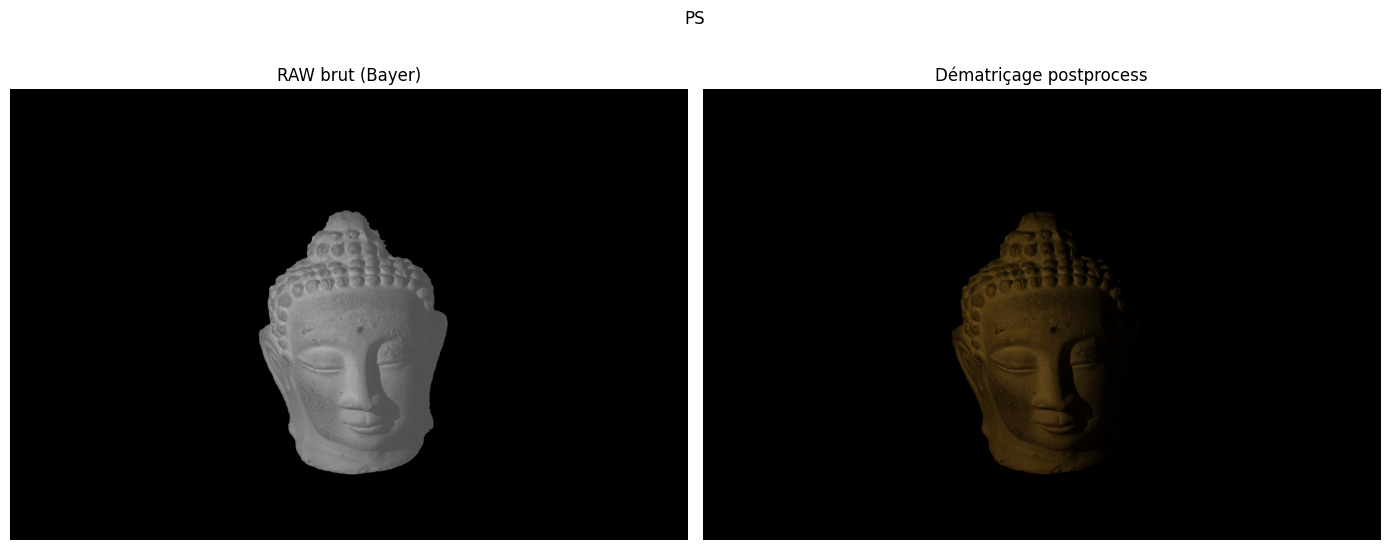

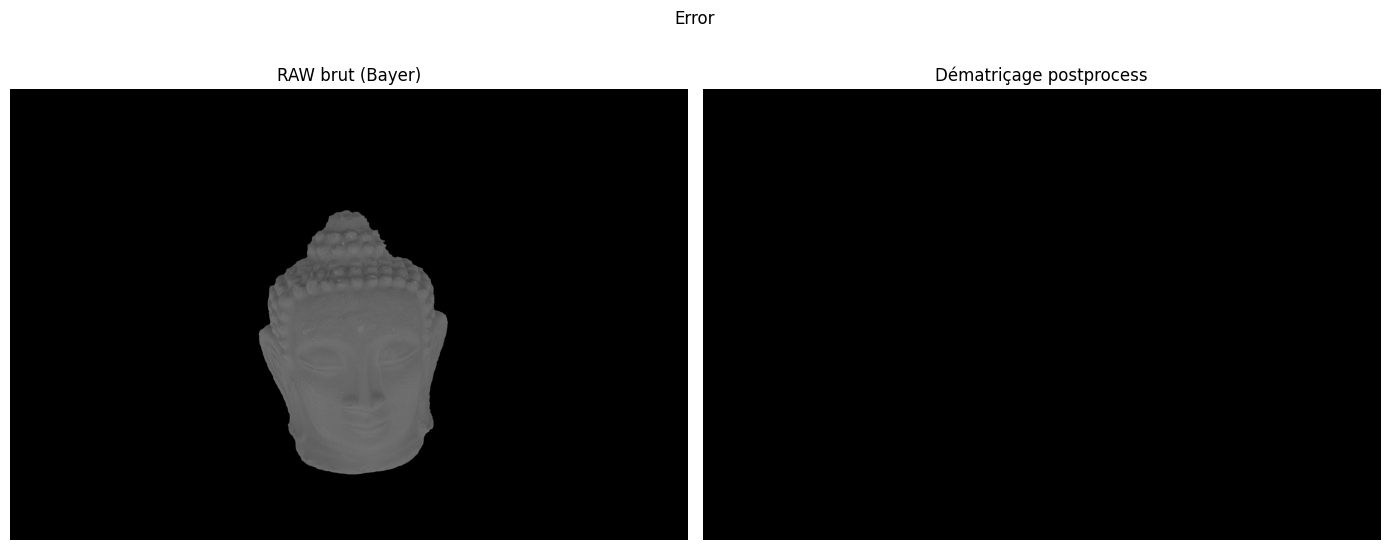

In [14]:
L_true = load_image_raw(path_L_true)
show_raw_and_post("PS", L_true, GAMA)

L_err = diff_raw(L_true, L_pred)
show_raw_and_post("Error", L_err, GAMA)